In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss
)

In [2]:
df = pd.read_csv('clean_df (1).csv')
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Sdng,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,False,4,0,1,0,0,0,1,0
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,False,4,0,1,0,0,0,1,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,True,False,4,0,1,0,0,0,1,0
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,False,4,0,1,0,0,0,1,0
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,False,4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,False,4,0,1,0,0,0,1,0
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,False,4,0,1,0,0,0,1,0
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,False,True,4,0,1,0,0,0,1,0
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,False,4,0,1,0,0,0,1,0


In [3]:
df['SalePrice_binned'] = pd.qcut(df['SalePrice'], q=5, labels=False)

In [4]:
df['SalePrice_binned'].value_counts()

,count
SalePrice_binned,
0,595
3,593
2,581
1,580
4,578


=> given the built in pd.qcut method, we discretisized the continuous target variable "SalePrice" into 4 classes

The qcut method uses a quantile based approach to discretize a continuous variable

Now, implementing xgboost for a Multi-Class classification, using SalePrice_binned as target variable

In [5]:
df

,MS SubClass,Lot Frontage,Lot Area,HouseStyle_MedianPrice,BldgType_MedianPrice,Neighborhood_MedianPrice,Combo_PriceMean,Overall Qual,Overall Cond,Year Built,...,Exterior2nd_Simp_Wd Shng,Functional_Encoded,SaleType_Best,SaleType_Good,SaleType_Average,SaleType_Low,SaleCond_High,SaleCond_Typical,SaleCond_Low,SalePrice_binned
0,20,141.0,31770,155000.0,165000.0,140000.0,140000.0,6,5,1960,...,False,4,0,1,0,0,0,1,0,3
1,20,80.0,11622,155000.0,165000.0,140000.0,140000.0,5,6,1961,...,False,4,0,1,0,0,0,1,0,0
2,20,81.0,14267,155000.0,165000.0,140000.0,140000.0,6,6,1958,...,False,4,0,1,0,0,0,1,0,2
3,20,93.0,11160,155000.0,165000.0,140000.0,140000.0,7,5,1968,...,False,4,0,1,0,0,0,1,0,4
4,60,74.0,13830,189000.0,165000.0,183000.0,185000.0,5,5,1997,...,False,4,0,1,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,37.0,7937,165000.0,165000.0,153500.0,158950.0,6,6,1984,...,False,4,0,1,0,0,0,1,0,1
2923,20,74.0,8885,155000.0,165000.0,153500.0,140000.0,5,5,1983,...,False,4,0,1,0,0,0,1,0,1
2924,85,62.0,10441,143000.0,165000.0,153500.0,153500.0,5,5,1992,...,True,4,0,1,0,0,0,1,0,1
2925,20,77.0,10010,155000.0,165000.0,153500.0,140000.0,5,5,1974,...,False,4,0,1,0,0,0,1,0,2


In [6]:
X = df.drop(columns=['SalePrice', 'SalePrice_binned'])
y = df['SalePrice_binned']

Firstly, implemented without stratification

In [7]:
'''80 test 20 train'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
xgb80_20 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)


In [9]:
xgb80_20.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [10]:
y_pred_80_20 = xgb80_20.predict(X_test)
y_pred_proba_80_20 = xgb80_20.predict_proba(X_test)
y_pred_80_20
y_pred_proba_80_20

array([[0.00668172, 0.00736774, 0.01377393, 0.05817899, 0.9139976 ],
       [0.28747633, 0.48347142, 0.17101167, 0.0320384 , 0.02600219],
       [0.02339986, 0.02651033, 0.36632574, 0.55858946, 0.02517465],
       ...,
       [0.00569842, 0.00628348, 0.00795654, 0.02305246, 0.95700914],
       [0.03600165, 0.04078722, 0.18277706, 0.59247   , 0.14796408],
       [0.18227063, 0.63760614, 0.11206552, 0.03376586, 0.0342919 ]],
      dtype=float32)

In [11]:
# accuracy
acc = accuracy_score(y_test, y_pred_80_20)
print(f"Accuracy: {acc:.4f}")

#  Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_80_20))

# 3. Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_80_20))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.58      0.61      0.59       121
           2       0.55      0.47      0.51       114
           3       0.68      0.73      0.71       120
           4       0.90      0.86      0.88       111

    accuracy                           0.70       586
   macro avg       0.70      0.70      0.70       586
weighted avg       0.69      0.70      0.69       586


Confusion Matrix:
 [[97 18  5  0  0]
 [24 74 19  4  0]
 [ 4 33 54 23  0]
 [ 0  2 19 88 11]
 [ 0  1  1 14 95]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

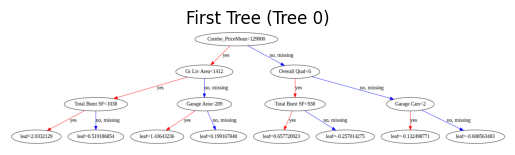

In [12]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb80_20, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()



In [13]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=0, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_tree0", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

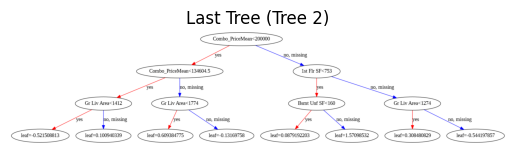

In [14]:
# last tree = index num_estimators - 1
last_tree_idx = xgb80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb80_20, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [15]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
# export first tree for a better visualization
# dot = to_graphviz(xgb80_20, num_trees=last_tree_idx, rankdir='UT')

# save as pdf
# dot.render("xgb80_20_lasttree", format="pdf")   # or format="svg"

'DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'

10 90 train test split without stratification and tree plot + eval

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
xgb90_10 = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='multi:softmax', num_class=5)

In [20]:
xgb90_10.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_class=5, ...)

In [21]:
y_pred_90_10 = xgb90_10.predict(X_test)
y_pred_proba_90_10 = xgb90_10.predict_proba(X_test)

In [23]:
# accuracy
acc = accuracy_score(y_test, y_pred_90_10)
print(f'Accuracy: {acc:.4f}')

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_90_10))

# confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_90_10))


Accuracy: 0.6962

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        54
           1       0.58      0.58      0.58        66
           2       0.54      0.52      0.53        54
           3       0.74      0.70      0.72        64
           4       0.92      0.84      0.88        55

    accuracy                           0.70       293
   macro avg       0.70      0.70      0.70       293
weighted avg       0.70      0.70      0.70       293


Confusion Matrix:
 [[47  7  0  0  0]
 [16 38 10  2  0]
 [ 2 18 28  6  0]
 [ 0  2 13 45  4]
 [ 0  0  1  8 46]]


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 8000x4000 with 0 Axes>

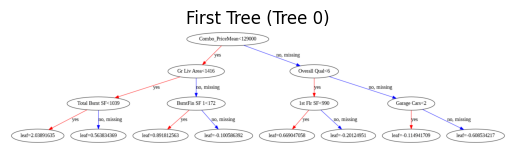

In [24]:
'''Plot first and last tree'''
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(xgb90_10, num_trees=0)
plt.title("First Tree (Tree 0)")
plt.show()

In [25]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''

dot = to_graphviz(xgb90_10, num_trees=0, rankdir='UT')

dot.render("xgb90_10_tree0", format="pdf")

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_tree0.pdf'

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

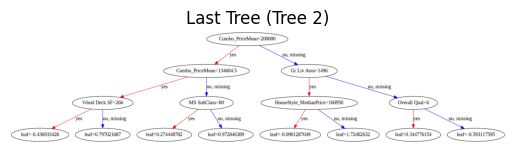

In [26]:
last_tree_idx = xgb90_10.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(xgb90_10, num_trees=last_tree_idx)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

In [27]:
'''DO NOT RUN, VISUALIZATION ALREADY EXPORTED AS PDF'''
dot = to_graphviz(xgb90_10, num_trees=last_tree_idx, rankdir='UT')

dot.render("xgb90_10_lasttree", format="pdf")   # or format="svg"

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


'xgb90_10_lasttree.pdf'